In [1]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from nltk.corpus import stopwords
import numpy as np
from urllib.request import urlopen
from urllib.error import URLError, HTTPError
import pandas as pd
import seaborn as sns 
from sklearn.cluster import KMeans
import string
import re
import burst_detection as bd
import warnings
import glob
from itertools import dropwhile
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import pickle
import os.path

In [2]:
#settings
%matplotlib inline
rcParams['figure.figsize'] = 15, 6
pd.set_option('display.max_colwidth', -1) #show full columns
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=np.inf)

In [3]:
#function to extract images stored in a df
def image_extract(x,file_name,n):
    x_sample = x.sample(n)
    img_urls = x_sample['image_url']
    for index, url in enumerate(img_urls):
        try:
            link = urlopen(url)
        except:
            print("Bad URL")
            continue
        try:
            name = "%s%s.jpg" % (file_name, (index+1))
            with open(name, "wb") as output:
                output.write(link.read())
        except IOError:
            print("Unable to create %s") % name

In [4]:
#word count function
def freq_dist(data, n_words):
    ngram_vectorizer = CountVectorizer(analyzer='word', tokenizer=word_tokenize, ngram_range=(1, 1), min_df=1)
    X = ngram_vectorizer.fit_transform(data)
    vocab = list(ngram_vectorizer.get_feature_names())
    counts = X.sum(axis=0).A1
    freq_distribution = Counter(dict(zip(vocab, counts)))
    return freq_distribution.most_common(n_words)

In [10]:
path = 'data'
allFiles = glob.glob(path + "/*.tsv")
df = pd.concat((pd.read_csv(f, delimiter='\t') for f in allFiles))

## PreProcessing

In [27]:
stop_word = set(stopwords.words('dutch'))
regex_pat = re.compile(r'[^a-zA-Z\s]', flags=re.IGNORECASE)
excludes = ['objecttype', 'file directory not found']

#df = df[~df['date'].str.contains('date')] #remove duplicate header rows
#df = df[~df['ocr'].astype(str).str.contains('|'.join(excludes))] #remove rows with restricted error msg
#df['date'] = df['date'].astype('datetime64[ns]') #convert dates 
#df = df.sort_values(by='date') #sort by dates
df['ocr_clean'] = df['ocr'].str.replace(regex_pat, '') #only keep words
df['ocr_clean'] = df['ocr_clean'].str.findall('\w{4,}').str.join(' ') #only keep words more than 3 chars
df['ocr_clean'] = df['ocr_clean'].str.lower().str.strip()
df['ocr_clean'] = df['ocr_clean'].str.strip()#lower and remove whitespaces
df['ocr_clean'] = [' '.join(filter(None,filter(lambda word: word not in stop_word, line))) for line in df['ocr_clean'].str.split(' ')]
df['words'] = df['ocr_clean'].apply(lambda x: x.lower().split())
#calculating proportion of characters relative to size of the advertisement. 
df['area'] = df['w'] * df['h']
df['string_length'] = df['ocr_clean'].str.len()
df['character_proportion'] = df['string_length'] / df ['area']
df = df[df['character_proportion'] < 10] #remove ads with lot of text (i.e. ocr errors)

df['publication_year'] = df['date'].apply(lambda x: x.year)
df['publication_month'] = df['date'].apply(lambda x: x.month)
df['publication_day'] = df['date'].apply(lambda x: x.day)

drop_cols = ['min_x', 'min_y', 'max_x', 'max_y', 'w', 'h', 'ocr', 'area']
df.drop(drop_cols, axis=1, inplace=True)

# Read / Write Pickles

In [34]:
def write_pickle(name, input_):
    '''
    name specifies where you want to write which file 
    input defines which variable you want to write as a pickle
    '''
    n_bytes = 2**31
    max_bytes = 2**31 - 1
    data = bytearray(n_bytes)
    bytes_out = pickle.dumps(input_)
    with open(name, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])
            

def read_pickle(name):
    n_bytes = 2**31
    max_bytes = 2**31 - 1
    data = bytearray(n_bytes)
    bytes_in = bytearray(0)
    input_size = os.path.getsize(name)
    with open(name, 'rb') as f_in:
        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)
    return pickle.loads(bytes_in)

In [30]:
write_pickle('ads.pkl', df)

In [35]:
df = read_pickle('ads.pkl')

In [240]:
car_brands = [
    r'\bopel\b',
    r'\brenault\b',
    r'\baudi\b',
    r'\bsimca\b',
    r'\bpeugeot\b',
    r'\bbuick\b',
    r'\bvolkswagen\b',
    r'\bford\b',
    r'\bStandard\b',
    r'\bTriumph\b',
    r'\bfiat\b',
    r'\bnissan\b',
    r'\bBMW\b',
    r'\bmercedes\b',
    r'\bporsche\b',
    r'\bdaewoo\b',
    r'\btoyota\b',
    r'\balfa romeo\b',
    r'\bsubaru\b',
    r'\bhonda\b',
    r'\blexus\b',
    r'\bmazda\b',
    r'\blada\b',
    r'\bhyundai\b',
    r'\bbentley\b',
    r'\bjaguar\b',
    r'\bcadillac\b',
    r'\bchevrolet\b',
    r'\bchrysler\b',
    r'\bjeep\b',
]

In [ ]:
car_df = df[df['ocr_clean'].str.contains('|'.join(car_brands))]
car_df = car_df[car_df['character_proportion'] < 0.00020] #car ads with image and text
car_df = ads_image.reset_index(drop=True)

In [8]:
#ads_image.to_pickle('ads_image.pkl')
#ads_df = pd.read_pickle('ads_image.pkl')

In [262]:
#ads_image_sample = ads_image.sample(frac=.25)
#image_extract(ads_image_sample, 'cars')

In [10]:
#parameters
min_df = 10

In [11]:
corpus = np.array(car_df['ocr_clean'])

# Chi-square

In [35]:
from sklearn.feature_selection import chi2

In [41]:
labels_decade = []
for index,row in ads_df.iterrows():
    if row['publication_year'] < 1950:
        labels_decade.append('1940')
    elif row['publication_year'] > 1949 & row['publication_year'] < 1960:
        labels_decade.append('1950')
    elif row['publication_year'] > 1959 & row['publication_year'] < 1970:
        labels_decade.append('1960')
    elif row['publication_year'] > 1969 & row['publication_year'] < 1980:
        labels_decade.append('1970')
    elif row['publication_year'] > 1979 & row['publication_year'] < 1990:
        labels_decade.append('1980')
    elif row['publication_year'] > 1989 & row['publication_year'] < 1999:
        labels_decade.append('1990')   

In [42]:
labels = []
for index,row in ads_df.iterrows():
    labels.append(row['publication_year'])   

In [43]:
keyness, _ = chi2(dtm, labels)
ranking = np.argsort(keyness)[::-1]

keyness, _ = chi2(dtm, labels_decade)
ranking2 = np.argsort(keyness)[::-1]

In [47]:
chi_words = vocab[ranking]
chi_words_decade = vocab[ranking2]

# TF-IDF words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(norm='l1', sublinear_tf=True, analyzer='word', lowercase=True, max_df = 0.1, min_df = min_df)
tfidf_matrix =  vectorizer.fit_transform(corpus)
scores = zip(vectorizer.get_feature_names(), np.asarray(tfidf_matrix.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
feature_list = []
tf_idf_words = []
for item in sorted_scores:
    feature_list.append({'word': item[0], 'score': item[1]})
    tf_idf_words.append(item[0])
features = pd.DataFrame(feature_list)

# Detecting Bursts
### Technique from: https://github.com/nmarinsek/burst_analysis/blob/master/fMRIarticle_bursts.ipynb

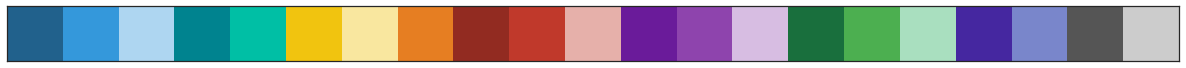

In [153]:
#format plots
sns.set(style='white', context='notebook', font_scale=1.5, 
        rc={'font.sans-serif': 'DejaVu Sans', 'lines.linewidth': 2.5})

#create a custom color palette
palette21 = ['#21618C', '#3498DB', '#AED6F1', '#00838F', '#00BFA5',
             '#F1C40F', '#F9E79F', '#E67E22', '#922B21', '#C0392B', 
             '#E6B0AA', '#6A1B9A', '#8E44AD', '#D7BDE2', '#196F3D', 
             '#4CAF50', '#A9DFBF', '#4527A0', '#7986CB', '#555555', 
             '#CCCCCC']
sns.palplot(palette21)

#create a color map
blog_blue = '#64C0C0'
blue_cmap = sns.light_palette(blog_blue, as_cmap=True)

In [154]:
#count the number of articles published each month
d = ads_df.groupby(['publication_year','publication_month'])['words'].count().reset_index(drop=True)

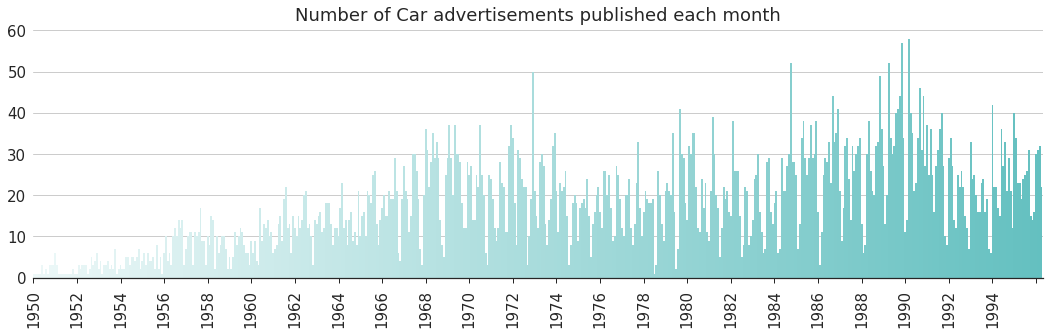

In [309]:
#plot the number of articles published each month
#initialize a figure
plt.figure(figsize=(15,5))
#plot bars
axes = plt.bar(d.index, d, width=1, color=blue_cmap(d.index.values/d.index.max()))  #color according to month

#format plot
plt.grid(axis='y')
plt.xlim(0,len(d))
plt.xticks(range(0,len(d),24), range(1950,1995,2), rotation=90)
plt.tick_params(axis='x', length=5)
plt.title('Number of Car advertisements published each month')
sns.despine(left=True)

plt.tight_layout()
plt.savefig('car_ads_per_month.png', dpi=300)

In [155]:
time_frame = ['publication_year', 'publication_month']
#create dataframe with word proportions
def word_proportions(df, word_list):
    all_r = pd.DataFrame(columns=word_list, index=d.index)
    for i, word in enumerate(word_list):
        all_r[word] = pd.concat([df.loc[:, time_frame],
                                df['words'].apply(lambda x: word in x)], axis=1) \
                               .groupby(by=time_frame).sum().reset_index(drop=True)
        if np.mod(i, 100)==0:
            print('total words', len(word_list), 'word', i, 'complete')
    return all_r

In [221]:
#all_r_avg_distinct = word_proportions(ads_df, avg_distinctive)
#all_rchi_words = word_proportions(ads_df, chi_words)
#all_r_tf_idf_words = word_proportions(ads_df, tf_idf_words)
#all_nmf_words = word_proportions(ads_df, nmf_words)
all_lda_words = word_proportions(ads_df, lda_words)

total words 1624 word 0 complete
total words 1624 word 100 complete
total words 1624 word 200 complete
total words 1624 word 300 complete
total words 1624 word 400 complete
total words 1624 word 500 complete
total words 1624 word 600 complete
total words 1624 word 700 complete
total words 1624 word 800 complete
total words 1624 word 900 complete
total words 1624 word 1000 complete
total words 1624 word 1100 complete
total words 1624 word 1200 complete
total words 1624 word 1300 complete
total words 1624 word 1400 complete
total words 1624 word 1500 complete
total words 1624 word 1600 complete


In [320]:
all_r_avg_distinct.to_pickle('all_r_avg_distinct.pkl')
all_rchi_words.to_pickle('all_r_chi-words.pkl')
all_r_tf_idf_words.to_pickle('all_r_tf_idf_words.pkl')

In [162]:
def find_bursts(d, all_r, word_list):
    '''
    burst detection function
    '''
    s = 2  #resolution of state jumps; higher s --> fewer but stronger bursts
    gam = 0.5 #difficulty of moving up a state; larger gamma --> harder to move up states, less bursty
    n = len(d) #number of timepoints
    smooth_win = 5
    
    all_bursts = pd.DataFrame(columns=['begin', 'end', 'weight'])
    
    for i, word, in enumerate(word_list):
        r = all_r.loc[:, word].astype(int)
        
        #find the optimal state sequence (using the Viterbi algorithm)
        [q,d,r,p] = bd.burst_detection(r,d,n,s,gam,smooth_win)
        
        #enumerate the bursts
        bursts = bd.enumerate_bursts(q, word)
        
        #find weights of each burst
        bursts_weighted = bd.burst_weights(bursts, r, d, p)
        
        #add the weighted burst to list of all bursts
        all_bursts = all_bursts.append(bursts_weighted, ignore_index=True)
        
        #print a progress report every 100 words
        if np.mod(i,100)==0:
            print('total words', len(word_list), 'word',i,'complete')
    
    return all_bursts.sort_values(by='weight', ascending=False)
    

In [222]:
#bursts_nmf = find_bursts(d, all_nmf_words, nmf_words)
bursts_lda = find_bursts(d, all_lda_words, lda_words)

total words 1624 word 0 complete
total words 1624 word 100 complete
total words 1624 word 200 complete
total words 1624 word 300 complete
total words 1624 word 400 complete
total words 1624 word 500 complete
total words 1624 word 600 complete
total words 1624 word 700 complete
total words 1624 word 800 complete
total words 1624 word 900 complete
total words 1624 word 1000 complete
total words 1624 word 1100 complete
total words 1624 word 1200 complete
total words 1624 word 1300 complete
total words 1624 word 1400 complete
total words 1624 word 1500 complete
total words 1624 word 1600 complete


In [164]:
bursts_avg_distinctive = find_bursts(d, all_r_avg_distinct, avg_distinctive)

NameError: name 'all_r_avg_distinct' is not defined

In [359]:
bursts_avg = find_bursts(d, all_r_avg_distinct, avg_distinctive)
bursts_chi = find_bursts(d, all_rchi_words, chi_words)
bursts_tfidf = find_bursts(d, all_r_tf_idf_words, tf_idf_words)

total words 10896 word 0 complete
total words 10896 word 100 complete
total words 10896 word 200 complete
total words 10896 word 300 complete
total words 10896 word 400 complete
total words 10896 word 500 complete
total words 10896 word 600 complete
total words 10896 word 700 complete
total words 10896 word 800 complete
total words 10896 word 900 complete
total words 10896 word 1000 complete
total words 10896 word 1100 complete
total words 10896 word 1200 complete
total words 10896 word 1300 complete
total words 10896 word 1400 complete
total words 10896 word 1500 complete
total words 10896 word 1600 complete
total words 10896 word 1700 complete
total words 10896 word 1800 complete
total words 10896 word 1900 complete
total words 10896 word 2000 complete
total words 10896 word 2100 complete
total words 10896 word 2200 complete
total words 10896 word 2300 complete
total words 10896 word 2400 complete
total words 10896 word 2500 complete
total words 10896 word 2600 complete
total words 1

In [361]:
bursts_avg_distinctive.to_pickle('burst_avg.pkl')
bursts_chi.to_pickle('burst_chi.pkl')
bursts_tfidf.to_pickle('burst_tfidf.pkl')

# Visualize 

In [191]:
def visualize_bursts(n_bursts, bursts, r, title):
    n = len(d) 
    top_bursts = bursts.sort_values(by='weight', ascending=False).reset_index(drop=True).loc[:n_bursts,:]
    #sort bursts by end date
    sorted_bursts = top_bursts.sort_values('end', ascending=False).reset_index(drop=True)
    #for burst that end at the last timepoint, sort by start
    last_timepoint = np.max(sorted_bursts['end'])
    sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:] = sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:].sort_values(by='begin', ascending=False).reset_index(drop=True)
    
    heatmap_data = r.loc[:,set(sorted_bursts['label'])]
    
    #find the baseline proportions sum(r)/sum(d) for each label
    baseline_p = heatmap_data.sum(axis=0) / d.sum()

    #convert r values into proportions at each timepoint
    heatmap_data = heatmap_data.apply(lambda x: x/d)

    #sort the rows according to the order used in the timeline
    order = sorted_bursts['label'].drop_duplicates(keep='last').values
    
    #transpose data and reindex the data according to the sorted word order
    heatmap_data = heatmap_data.T.reindex(order)

    #optional: demean proportions
    #heatmap_data = heatmap_data - heatmap_data.mean(axis=1)

    #optional: convert proportions into multiples of the baseline proportion
    heatmap_data = heatmap_data.apply(lambda x: x/baseline_p[x.index])

    #smooth proportions with the same smoothing window used in burst detection
    smoothed_heatmap_data = heatmap_data.rolling(window=5, center=True, axis=1).mean()

    #create the heatmap
    plt.figure(figsize=(10,30))
    ax = sns.heatmap(smoothed_heatmap_data[::-1], vmin=0, vmax=2.5, cmap=blue_cmap, yticklabels=True,
                 cbar_kws = dict(use_gridspec=False, location="bottom", pad=0.05, shrink=0.7))
    plt.title('Normalized proportions of "bursting" ' + title + ' words over time')
    plt.xticks(range(0,n,24), range(1945,1995,2), rotation='vertical')

    #create boxes around bursting periods
    for index, burst in sorted_bursts.iterrows():
        
        #define outline positions
        y = smoothed_heatmap_data.index.get_loc(burst['label'])
        y = len(smoothed_heatmap_data) - y - 1 #reverse since it counts from bottom
        xstart = burst['begin'] 
        width = burst['end'] - burst['begin'] + 1
    
        #draw rectangle
        ax.add_patch(plt.Rectangle((xstart,y), width, height=1, alpha=1, 
                           facecolor='none', edgecolor='k', linewidth=1))
    plt.savefig(title + "_heatmap.png", bbox_inches="tight", dpi=300)

In [185]:
visualize_bursts(100, bursts_avg_distinctive, all_r_avg_distinct, 'avg')
visualize_bursts(100, bursts_tfidf, all_r_tf_idf_words, 'tfidf')
visualize_bursts(100, bursts_chi, all_rchi_words, 'chi')

NameError: name 'all_r_avg_distinct' is not defined

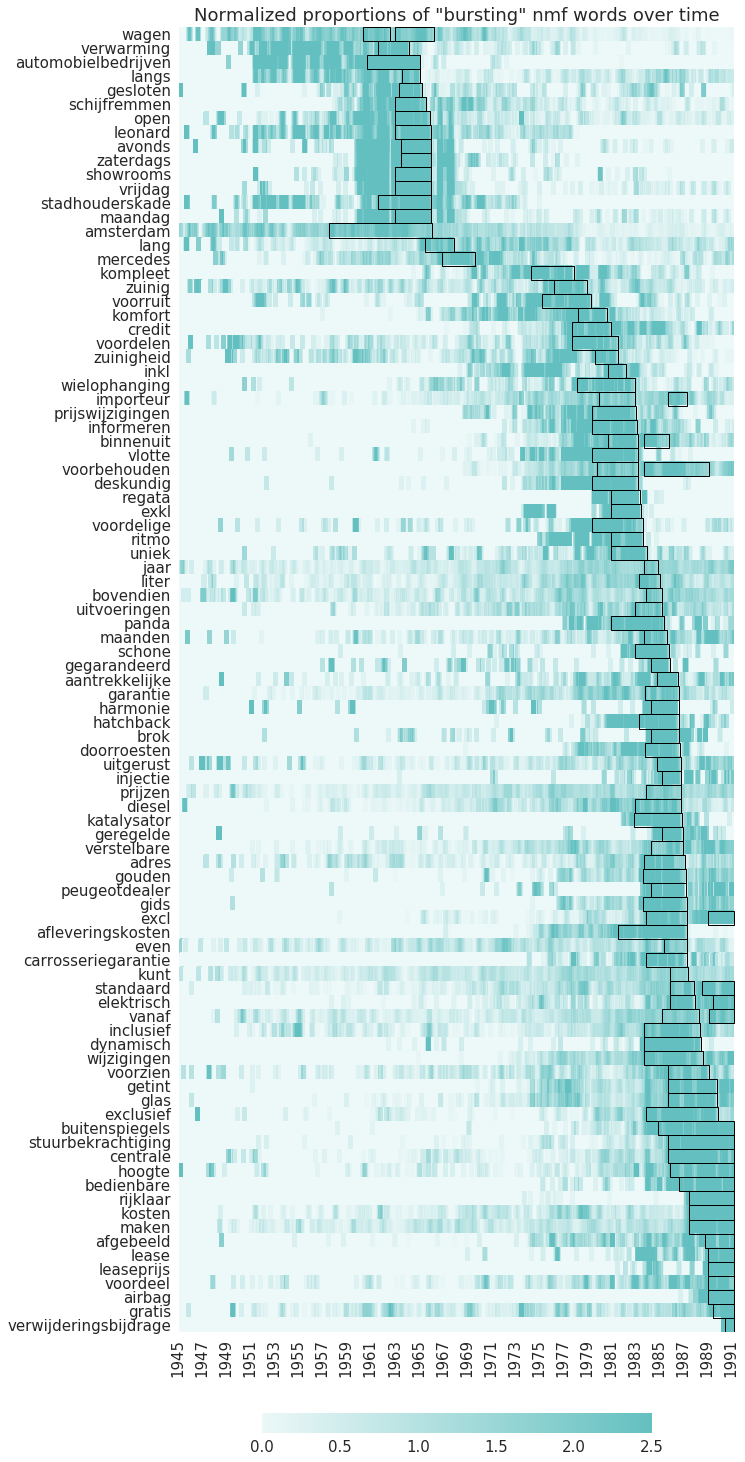

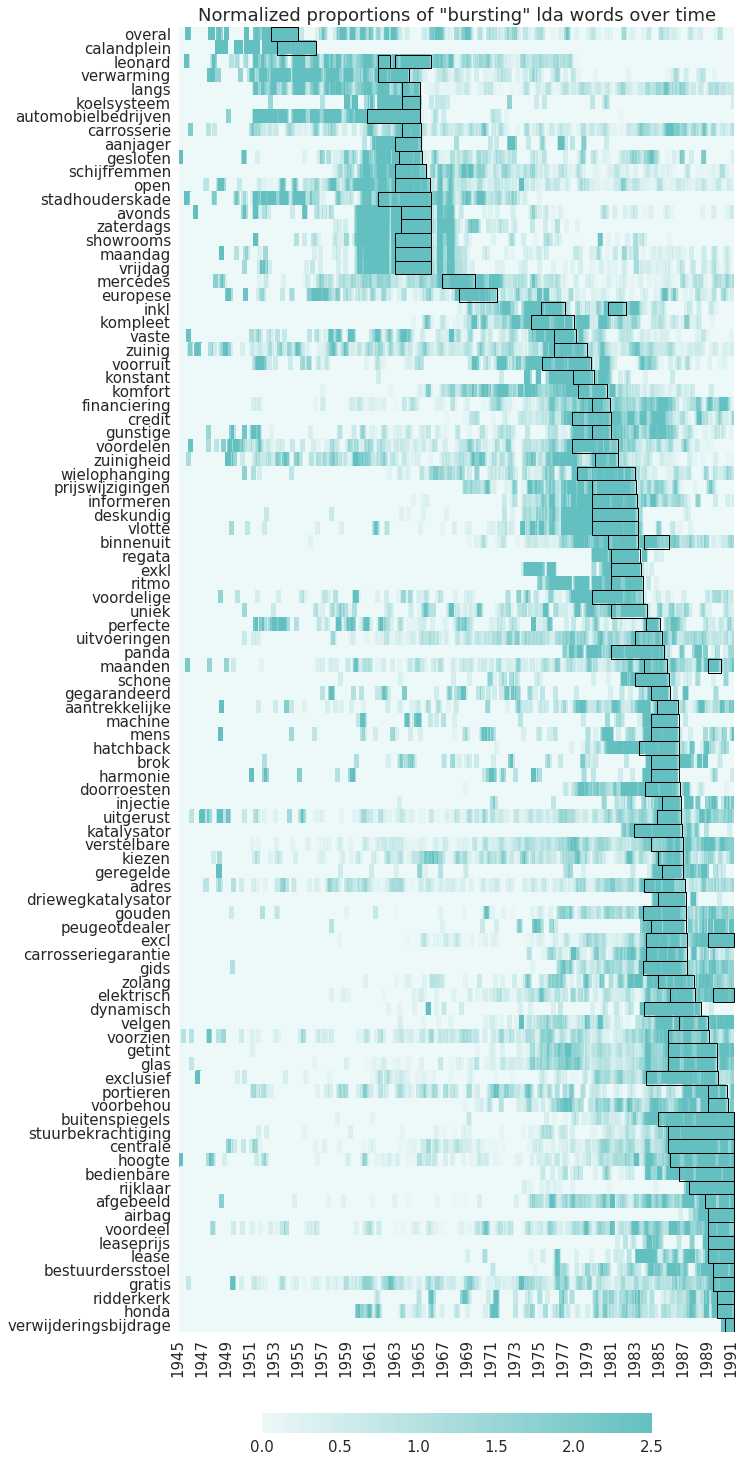

In [223]:
visualize_bursts(100, bursts_nmf, all_nmf_words, 'nmf')
visualize_bursts(100, bursts_lda, all_lda_words, 'lda')

## Gensim Topic Modeling

In [67]:
from nltk import word_tokenize
from gensim import corpora
from gensim import models
import pyLDAvis
import pyLDAvis.gensim
import pandas as pd
from gensim.corpora import Dictionary
import seaborn as sns
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [230]:
docs = np.array(ads_df['ocr_clean'])
docs = [document.split() for document in docs]

In [232]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=.1) #very strict pruning similar to tf-idf pruning
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

2018-03-06 17:50:22,492 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-06 17:50:24,151 : INFO : built Dictionary(210809 unique tokens: ['ford', 'nederla', 'voedselvoorziening', 'wederopbouw', 'aangesteld']...) from 9863 documents (total 1111173 corpus positions)
2018-03-06 17:50:24,442 : INFO : discarding 201807 tokens: [('ford', 1693), ('voedselvoorziening', 1), ('wederopbouw', 3), ('aarom', 4), ('amiler', 1), ('amsterdam', 2540), ('aners', 2), ('bedreven', 1), ('drura', 1), ('dusverre', 1)]...
2018-03-06 17:50:24,443 : INFO : keeping 9002 tokens which were in no less than 10 and no more than 986 (=10.0%) documents
2018-03-06 17:50:24,504 : INFO : resulting dictionary: Dictionary(9002 unique tokens: ['nederla', 'aangesteld', 'amsterdamsche', 'automobiel', 'automobilisten']...)


Number of unique tokens: 9002
Number of documents: 9863


In [233]:
# Train LDA model.

from gensim.models import LdaModel, LdaMulticore
from multiprocessing import cpu_count

# Set training parameters.
num_topics = 20
#chunksize = 2000
passes = 20
iterations = 500
eval_every = 5  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = LdaModel(corpus=corpus, id2word=id2word, alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics,passes=passes, eval_every=eval_every)
#%time model = LdaMulticore(corpus=corpus, id2word=id2word, eta='auto', workers=cpu_count()-1, iterations=iterations, num_topics=num_topics,passes=passes, eval_every=eval_every)

2018-03-06 17:50:35,427 : INFO : using autotuned alpha, starting with [0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001, 0.050000001]
2018-03-06 17:50:35,429 : INFO : using serial LDA version on this node
2018-03-06 17:50:36,289 : INFO : running online (multi-pass) LDA training, 20 topics, 20 passes over the supplied corpus of 9863 documents, updating model once every 2000 documents, evaluating perplexity every 9863 documents, iterating 500x with a convergence threshold of 0.001000
2018-03-06 17:50:36,290 : INFO : PROGRESS: pass 0, at document #2000/9863
2018-03-06 17:50:44,813 : INFO : optimized alpha [0.04420501, 0.042423233, 0.043200467, 0.043142609, 0.041207358, 0.042567834, 0.041492604, 0.040948547, 0.041865475, 0.043787777, 0.043146525, 0.041555248, 0.041785665, 0.041826617, 0.04450465,

2018-03-06 17:51:06,540 : INFO : topic #1 (0.050): 0.010*"stationwagon" + 0.010*"astra" + 0.008*"young" + 0.006*"rekord" + 0.006*"offerte" + 0.006*"motors" + 0.005*"general" + 0.005*"imotor" + 0.005*"holland" + 0.005*"cabrio"
2018-03-06 17:51:06,541 : INFO : topic #19 (0.073): 0.016*"audi" + 0.009*"volkswagen" + 0.008*"elektronische" + 0.007*"voorzien" + 0.007*"kleppen" + 0.006*"wieldoppen" + 0.006*"golf" + 0.006*"grille" + 0.005*"onze" + 0.005*"komfort"
2018-03-06 17:51:06,542 : INFO : topic #14 (0.083): 0.037*"excl" + 0.006*"lening" + 0.005*"schade" + 0.005*"voorstoelen" + 0.004*"voorzien" + 0.004*"benzine" + 0.003*"benzinemotoren" + 0.003*"maand" + 0.003*"verstelbare" + 0.003*"vier"
2018-03-06 17:51:06,543 : INFO : topic #0 (0.096): 0.015*"escort" + 0.013*"binnenuit" + 0.011*"afgebeeld" + 0.007*"voordeel" + 0.005*"bijvoorbeeld" + 0.005*"techniek" + 0.005*"uitvoering" + 0.004*"komfort" + 0.004*"keuze" + 0.004*"interieur"
2018-03-06 17:51:06,544 : INFO : topic diff=1.130511, rho=0.447

2018-03-06 17:51:31,150 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-03-06 17:51:31,242 : INFO : topic #3 (0.054): 0.116*"telefoon" + 0.062*"chrysler" + 0.015*"daewoo" + 0.011*"voyager" + 0.011*"elektrisch" + 0.009*"hyundai" + 0.009*"jeep" + 0.007*"cars" + 0.007*"import" + 0.007*"service"
2018-03-06 17:51:31,243 : INFO : topic #1 (0.055): 0.027*"astra" + 0.015*"stationwagon" + 0.014*"motors" + 0.013*"rekord" + 0.012*"general" + 0.008*"young" + 0.007*"juni" + 0.007*"geldzaken" + 0.007*"tipo" + 0.006*"maestro"
2018-03-06 17:51:31,244 : INFO : topic #19 (0.096): 0.023*"audi" + 0.015*"volkswagen" + 0.012*"golf" + 0.010*"polo" + 0.008*"elektronische" + 0.007*"voorzien" + 0.006*"onze" + 0.006*"grille" + 0.005*"wieldoppen" + 0.005*"kleppen"
2018-03-06 17:51:31,245 : INFO : topic #14 (0.121): 0.034*"excl" + 0.005*"lening" + 0.005*"schade" + 0.005*"voorstoelen" + 0.004*"benzine" + 0.004*"voorzien" + 0.004*"vier" + 0.004*"dankzij" + 0.003*"maand" + 0.003*"benz

2018-03-06 17:51:45,996 : INFO : PROGRESS: pass 2, at document #9863/9863
2018-03-06 17:51:48,284 : INFO : optimized alpha [0.22924477, 0.061542634, 0.09195175, 0.058416732, 0.080158561, 0.11043531, 0.086209401, 0.098882429, 0.078173459, 0.099848025, 0.095667765, 0.10068626, 0.10429781, 0.073322877, 0.16452017, 0.083041206, 0.082139872, 0.066907249, 0.087387897, 0.11762699]
2018-03-06 17:51:48,286 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-03-06 17:51:48,359 : INFO : topic #3 (0.058): 0.126*"telefoon" + 0.066*"chrysler" + 0.015*"daewoo" + 0.011*"hyundai" + 0.011*"voyager" + 0.010*"jeep" + 0.009*"elektrisch" + 0.009*"service" + 0.009*"cars" + 0.008*"haag"
2018-03-06 17:51:48,360 : INFO : topic #1 (0.062): 0.041*"astra" + 0.019*"stationwagon" + 0.018*"motors" + 0.017*"general" + 0.016*"rekord" + 0.009*"geldzaken" + 0.009*"tipo" + 0.009*"juni" + 0.008*"maestro" + 0.008*"young"
2018-03-06 17:51:48,361 : INFO : topic #19 (0.118): 0.027*"audi" + 0.020*"v

2018-03-06 17:51:58,359 : INFO : topic diff=0.390683, rho=0.334609
2018-03-06 17:52:02,747 : INFO : -8.204 per-word bound, 294.9 perplexity estimate based on a held-out corpus of 1863 documents with 143163 words
2018-03-06 17:52:02,747 : INFO : PROGRESS: pass 3, at document #9863/9863
2018-03-06 17:52:04,932 : INFO : optimized alpha [0.30780986, 0.06782873, 0.10726899, 0.06345053, 0.088404812, 0.13102457, 0.095152736, 0.11083183, 0.087719955, 0.11704461, 0.11092184, 0.11757811, 0.12210682, 0.079878859, 0.21013556, 0.093638197, 0.092507422, 0.073759414, 0.10273146, 0.13639088]
2018-03-06 17:52:04,934 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-03-06 17:52:04,997 : INFO : topic #3 (0.063): 0.131*"telefoon" + 0.068*"chrysler" + 0.015*"daewoo" + 0.013*"hyundai" + 0.011*"voyager" + 0.010*"service" + 0.010*"jeep" + 0.010*"haag" + 0.009*"cars" + 0.009*"elektrisch"
2018-03-06 17:52:04,997 : INFO : topic #1 (0.068): 0.046*"astra" + 0.021*"motors" + 0.020*"st

2018-03-06 17:52:14,592 : INFO : topic #0 (0.365): 0.009*"binnenuit" + 0.007*"escort" + 0.007*"komfort" + 0.006*"techniek" + 0.005*"afgebeeld" + 0.005*"motoren" + 0.005*"nieuw" + 0.004*"meest" + 0.004*"uitvoering" + 0.004*"aantal"
2018-03-06 17:52:14,594 : INFO : topic diff=0.396277, rho=0.317316
2018-03-06 17:52:19,077 : INFO : -8.164 per-word bound, 286.9 perplexity estimate based on a held-out corpus of 1863 documents with 143163 words
2018-03-06 17:52:19,078 : INFO : PROGRESS: pass 4, at document #9863/9863
2018-03-06 17:52:21,226 : INFO : optimized alpha [0.39386103, 0.0742158, 0.12202086, 0.068489328, 0.095943257, 0.14955153, 0.10331807, 0.12063924, 0.096443221, 0.13281354, 0.12528166, 0.13319941, 0.13835281, 0.085813925, 0.25554138, 0.10355736, 0.1019444, 0.079944581, 0.11721709, 0.15218417]
2018-03-06 17:52:21,228 : INFO : merging changes from 1863 documents into a model of 9863 documents
2018-03-06 17:52:21,283 : INFO : topic #3 (0.068): 0.134*"telefoon" + 0.068*"chrysler" + 0

2018-03-06 17:52:31,056 : INFO : topic #14 (0.281): 0.016*"excl" + 0.005*"benzine" + 0.005*"zuinig" + 0.005*"plaats" + 0.005*"vier" + 0.005*"schade" + 0.004*"rijplezier" + 0.004*"stad" + 0.004*"onderhoud" + 0.004*"granada"
2018-03-06 17:52:31,058 : INFO : topic #0 (0.459): 0.009*"binnenuit" + 0.007*"komfort" + 0.006*"techniek" + 0.006*"escort" + 0.005*"nieuw" + 0.005*"motoren" + 0.005*"afgebeeld" + 0.004*"meest" + 0.004*"aantal" + 0.004*"uitvoering"
2018-03-06 17:52:31,059 : INFO : topic diff=0.390923, rho=0.302455
2018-03-06 17:52:35,603 : INFO : -8.135 per-word bound, 281.0 perplexity estimate based on a held-out corpus of 1863 documents with 143163 words
2018-03-06 17:52:35,604 : INFO : PROGRESS: pass 5, at document #9863/9863
2018-03-06 17:52:37,817 : INFO : optimized alpha [0.48889738, 0.080462597, 0.13565366, 0.073598891, 0.10293821, 0.16631371, 0.11043893, 0.12884584, 0.10458153, 0.14673904, 0.13837087, 0.1481393, 0.15326877, 0.090958603, 0.30105028, 0.11251887, 0.1104206, 0.085

2018-03-06 17:52:47,604 : INFO : topic #5 (0.170): 0.017*"gratis" + 0.016*"ohra" + 0.016*"hertz" + 0.013*"betaalt" + 0.011*"eigen" + 0.010*"onze" + 0.009*"betalen" + 0.008*"huidige" + 0.008*"informatie" + 0.007*"januari"
2018-03-06 17:52:47,605 : INFO : topic #14 (0.326): 0.015*"excl" + 0.006*"zuinig" + 0.006*"benzine" + 0.005*"plaats" + 0.005*"vier" + 0.005*"rijplezier" + 0.004*"schade" + 0.004*"stad" + 0.004*"onderhoud" + 0.004*"granada"
2018-03-06 17:52:47,607 : INFO : topic #0 (0.555): 0.009*"binnenuit" + 0.006*"komfort" + 0.006*"techniek" + 0.005*"nieuw" + 0.005*"motoren" + 0.005*"afgebeeld" + 0.004*"meest" + 0.004*"binnen" + 0.004*"aantal" + 0.004*"escort"
2018-03-06 17:52:47,609 : INFO : topic diff=0.380184, rho=0.289503
2018-03-06 17:52:52,270 : INFO : -8.112 per-word bound, 276.6 perplexity estimate based on a held-out corpus of 1863 documents with 143163 words
2018-03-06 17:52:52,271 : INFO : PROGRESS: pass 6, at document #9863/9863
2018-03-06 17:52:54,412 : INFO : optimized 

2018-03-06 17:53:04,544 : INFO : topic #1 (0.087): 0.058*"kadett" + 0.033*"motors" + 0.033*"rekord" + 0.029*"general" + 0.023*"opeldealer" + 0.019*"tipo" + 0.017*"rotterdam" + 0.016*"maestro" + 0.015*"astra" + 0.013*"caravan"
2018-03-06 17:53:04,545 : INFO : topic #5 (0.184): 0.017*"gratis" + 0.016*"ohra" + 0.016*"hertz" + 0.013*"betaalt" + 0.011*"eigen" + 0.010*"onze" + 0.008*"betalen" + 0.008*"huidige" + 0.008*"informatie" + 0.007*"januari"
2018-03-06 17:53:04,546 : INFO : topic #14 (0.373): 0.015*"excl" + 0.006*"zuinig" + 0.006*"benzine" + 0.005*"plaats" + 0.005*"vier" + 0.005*"rijplezier" + 0.004*"schade" + 0.004*"onderhoud" + 0.004*"stad" + 0.004*"comfortabel"
2018-03-06 17:53:04,547 : INFO : topic #0 (0.641): 0.008*"binnenuit" + 0.006*"komfort" + 0.006*"techniek" + 0.006*"nieuw" + 0.005*"motoren" + 0.005*"meest" + 0.004*"afgebeeld" + 0.004*"binnen" + 0.004*"aantal" + 0.004*"prestaties"
2018-03-06 17:53:04,548 : INFO : topic diff=0.366349, rho=0.278084
2018-03-06 17:53:08,839 : IN

2018-03-06 17:53:19,733 : INFO : topic #3 (0.087): 0.120*"telefoon" + 0.059*"chrysler" + 0.014*"service" + 0.013*"haag" + 0.013*"kunstleer" + 0.012*"hyundai" + 0.010*"rotterdam" + 0.010*"telefoo" + 0.009*"haarlem" + 0.008*"autobedrijf"
2018-03-06 17:53:19,734 : INFO : topic #1 (0.092): 0.065*"kadett" + 0.034*"motors" + 0.033*"rekord" + 0.029*"general" + 0.024*"opeldealer" + 0.020*"tipo" + 0.017*"rotterdam" + 0.016*"maestro" + 0.016*"astra" + 0.013*"caravan"
2018-03-06 17:53:19,735 : INFO : topic #5 (0.195): 0.018*"gratis" + 0.017*"hertz" + 0.017*"ohra" + 0.012*"betaalt" + 0.011*"eigen" + 0.010*"onze" + 0.008*"huidige" + 0.008*"betalen" + 0.008*"informatie" + 0.008*"januari"
2018-03-06 17:53:19,736 : INFO : topic #14 (0.420): 0.015*"excl" + 0.006*"zuinig" + 0.006*"benzine" + 0.006*"plaats" + 0.005*"vier" + 0.005*"rijplezier" + 0.004*"onderhoud" + 0.004*"schade" + 0.004*"stad" + 0.004*"comfortabel"
2018-03-06 17:53:19,737 : INFO : topic #0 (0.715): 0.008*"binnenuit" + 0.006*"komfort" + 0

2018-03-06 17:53:38,316 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-03-06 17:53:38,366 : INFO : topic #3 (0.091): 0.122*"telefoon" + 0.060*"chrysler" + 0.014*"service" + 0.014*"haag" + 0.013*"kunstleer" + 0.012*"hyundai" + 0.011*"rotterdam" + 0.010*"telefoo" + 0.009*"autobedrijf" + 0.009*"haarlem"
2018-03-06 17:53:38,368 : INFO : topic #1 (0.097): 0.069*"kadett" + 0.034*"motors" + 0.033*"rekord" + 0.030*"general" + 0.025*"opeldealer" + 0.020*"tipo" + 0.017*"rotterdam" + 0.016*"astra" + 0.016*"maestro" + 0.013*"caravan"
2018-03-06 17:53:38,370 : INFO : topic #5 (0.204): 0.018*"gratis" + 0.017*"hertz" + 0.017*"ohra" + 0.011*"betaalt" + 0.011*"eigen" + 0.010*"onze" + 0.008*"huidige" + 0.008*"informatie" + 0.008*"januari" + 0.007*"betalen"
2018-03-06 17:53:38,372 : INFO : topic #14 (0.464): 0.014*"excl" + 0.006*"benzine" + 0.006*"zuinig" + 0.006*"plaats" + 0.005*"vier" + 0.005*"rijplezier" + 0.004*"onderhoud" + 0.004*"schade" + 0.004*"comfortabel" + 0.0

2018-03-06 17:53:57,316 : INFO : optimized alpha [0.83272797, 0.10077824, 0.18847446, 0.094089411, 0.13065471, 0.21227543, 0.13207565, 0.14932717, 0.13070504, 0.19511594, 0.17796949, 0.18763782, 0.19578212, 0.1060294, 0.50430864, 0.13262984, 0.14176318, 0.1047039, 0.18483299, 0.19814685]
2018-03-06 17:53:57,318 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-03-06 17:53:57,349 : INFO : topic #3 (0.094): 0.124*"telefoon" + 0.060*"chrysler" + 0.014*"service" + 0.014*"haag" + 0.013*"kunstleer" + 0.012*"hyundai" + 0.011*"rotterdam" + 0.011*"telefoo" + 0.010*"autobedrijf" + 0.010*"haarlem"
2018-03-06 17:53:57,350 : INFO : topic #1 (0.101): 0.070*"kadett" + 0.035*"motors" + 0.033*"rekord" + 0.030*"general" + 0.026*"opeldealer" + 0.021*"tipo" + 0.017*"rotterdam" + 0.017*"astra" + 0.016*"maestro" + 0.013*"caravan"
2018-03-06 17:53:57,352 : INFO : topic #5 (0.212): 0.018*"gratis" + 0.018*"hertz" + 0.017*"ohra" + 0.011*"eigen" + 0.010*"betaalt" + 0.010*"onze" + 0

2018-03-06 17:54:08,951 : INFO : topic diff=0.317508, rho=0.243026
2018-03-06 17:54:08,970 : INFO : PROGRESS: pass 11, at document #8000/9863
2018-03-06 17:54:10,861 : INFO : optimized alpha [0.87919283, 0.10442481, 0.19607092, 0.097123772, 0.13468172, 0.21866794, 0.1349798, 0.1525795, 0.13558078, 0.20131974, 0.18370047, 0.19614039, 0.20413844, 0.10847583, 0.53936869, 0.13651852, 0.14662023, 0.10749853, 0.1918292, 0.20315012]
2018-03-06 17:54:10,863 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-03-06 17:54:10,892 : INFO : topic #3 (0.097): 0.126*"telefoon" + 0.060*"chrysler" + 0.014*"service" + 0.014*"haag" + 0.013*"kunstleer" + 0.012*"hyundai" + 0.011*"rotterdam" + 0.011*"telefoo" + 0.011*"autobedrijf" + 0.010*"haarlem"
2018-03-06 17:54:10,893 : INFO : topic #1 (0.104): 0.071*"kadett" + 0.035*"motors" + 0.033*"rekord" + 0.031*"general" + 0.026*"opeldealer" + 0.021*"tipo" + 0.017*"astra" + 0.017*"rotterdam" + 0.016*"maestro" + 0.014*"caravan"
2018-03-

2018-03-06 17:54:22,526 : INFO : topic #0 (0.868): 0.007*"nieuw" + 0.006*"komfort" + 0.005*"motoren" + 0.005*"techniek" + 0.005*"meest" + 0.005*"binnen" + 0.005*"binnenuit" + 0.004*"prestaties" + 0.004*"taunus" + 0.004*"aantal"
2018-03-06 17:54:22,527 : INFO : topic diff=0.303770, rho=0.236152
2018-03-06 17:54:22,545 : INFO : PROGRESS: pass 12, at document #8000/9863
2018-03-06 17:54:24,530 : INFO : optimized alpha [0.91991299, 0.10758383, 0.20264079, 0.099583924, 0.13826846, 0.22458069, 0.13739175, 0.15522078, 0.13980755, 0.20671047, 0.18850781, 0.20388912, 0.21164905, 0.11058158, 0.56964791, 0.13994271, 0.15126659, 0.10994686, 0.19784322, 0.20731424]
2018-03-06 17:54:24,532 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-03-06 17:54:24,562 : INFO : topic #3 (0.100): 0.127*"telefoon" + 0.061*"chrysler" + 0.014*"service" + 0.014*"haag" + 0.013*"kunstleer" + 0.012*"hyundai" + 0.012*"rotterdam" + 0.011*"telefoo" + 0.011*"autobedrijf" + 0.010*"haarlem"
201

2018-03-06 17:54:36,521 : INFO : topic #14 (0.577): 0.011*"excl" + 0.006*"benzine" + 0.006*"zuinig" + 0.006*"plaats" + 0.006*"vier" + 0.005*"veilig" + 0.005*"onderhoud" + 0.004*"idem" + 0.004*"schade" + 0.004*"comfortabel"
2018-03-06 17:54:36,522 : INFO : topic #0 (0.904): 0.007*"nieuw" + 0.006*"komfort" + 0.005*"motoren" + 0.005*"meest" + 0.005*"techniek" + 0.005*"binnen" + 0.005*"binnenuit" + 0.004*"prestaties" + 0.004*"aantal" + 0.004*"taunus"
2018-03-06 17:54:36,523 : INFO : topic diff=0.290769, rho=0.229830
2018-03-06 17:54:36,541 : INFO : PROGRESS: pass 13, at document #8000/9863
2018-03-06 17:54:38,505 : INFO : optimized alpha [0.95576584, 0.11033297, 0.20857339, 0.101636, 0.14159141, 0.22966973, 0.13954265, 0.15745878, 0.14330201, 0.21132599, 0.19260699, 0.21092935, 0.21812312, 0.11243042, 0.59580308, 0.14282401, 0.15556936, 0.11213522, 0.20301887, 0.21084669]
2018-03-06 17:54:38,507 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-03-06 17:54:38

2018-03-06 17:54:50,479 : INFO : topic #5 (0.227): 0.026*"hertz" + 0.019*"gratis" + 0.014*"ohra" + 0.012*"eigen" + 0.011*"onze" + 0.010*"zegt" + 0.007*"informatie" + 0.007*"claim" + 0.007*"korting" + 0.007*"huidige"
2018-03-06 17:54:50,480 : INFO : topic #14 (0.600): 0.011*"excl" + 0.006*"benzine" + 0.006*"zuinig" + 0.006*"plaats" + 0.006*"vier" + 0.005*"veilig" + 0.005*"onderhoud" + 0.004*"comfortabel" + 0.004*"geven" + 0.004*"idem"
2018-03-06 17:54:50,481 : INFO : topic #0 (0.936): 0.007*"nieuw" + 0.006*"komfort" + 0.005*"motoren" + 0.005*"meest" + 0.005*"binnen" + 0.005*"techniek" + 0.005*"binnenuit" + 0.004*"prestaties" + 0.004*"aantal" + 0.004*"taunus"
2018-03-06 17:54:50,482 : INFO : topic diff=0.278214, rho=0.223991
2018-03-06 17:54:50,499 : INFO : PROGRESS: pass 14, at document #8000/9863
2018-03-06 17:54:52,395 : INFO : optimized alpha [0.98733515, 0.11282361, 0.21392003, 0.10341199, 0.14449719, 0.23384097, 0.14142194, 0.15926436, 0.14622743, 0.2152358, 0.19580273, 0.21740773,

2018-03-06 17:55:04,266 : INFO : topic #1 (0.113): 0.068*"kadett" + 0.040*"rekord" + 0.037*"motors" + 0.032*"general" + 0.027*"astra" + 0.021*"opeldealer" + 0.016*"tipo" + 0.016*"stationwagon" + 0.015*"caravan" + 0.015*"rotterdam"
2018-03-06 17:55:04,267 : INFO : topic #5 (0.231): 0.026*"hertz" + 0.019*"gratis" + 0.014*"ohra" + 0.012*"eigen" + 0.011*"onze" + 0.010*"zegt" + 0.008*"informatie" + 0.007*"claim" + 0.007*"korting" + 0.007*"huidige"
2018-03-06 17:55:04,269 : INFO : topic #14 (0.621): 0.011*"excl" + 0.007*"benzine" + 0.006*"plaats" + 0.006*"zuinig" + 0.006*"vier" + 0.005*"veilig" + 0.005*"onderhoud" + 0.004*"comfortabel" + 0.004*"geven" + 0.004*"vele"
2018-03-06 17:55:04,269 : INFO : topic #0 (0.965): 0.007*"nieuw" + 0.006*"komfort" + 0.005*"motoren" + 0.005*"binnen" + 0.005*"meest" + 0.005*"techniek" + 0.005*"binnenuit" + 0.004*"prestaties" + 0.004*"aantal" + 0.004*"keuze"
2018-03-06 17:55:04,270 : INFO : topic diff=0.266265, rho=0.218575
2018-03-06 17:55:04,288 : INFO : PROG

2018-03-06 17:55:18,053 : INFO : topic #3 (0.109): 0.133*"telefoon" + 0.065*"chrysler" + 0.016*"haag" + 0.015*"service" + 0.015*"kunstleer" + 0.013*"autobedrijf" + 0.013*"rotterdam" + 0.012*"telefoo" + 0.011*"haarlem" + 0.009*"dodge"
2018-03-06 17:55:18,056 : INFO : topic #13 (0.115): 0.082*"alfa" + 0.034*"romeo" + 0.015*"super" + 0.014*"goedkoopstraat" + 0.013*"chevron" + 0.012*"danil" + 0.011*"gebruikelijke" + 0.010*"nationalenederlanden" + 0.009*"benzine" + 0.009*"aktie"
2018-03-06 17:55:18,057 : INFO : topic #5 (0.234): 0.026*"hertz" + 0.019*"gratis" + 0.015*"ohra" + 0.012*"eigen" + 0.010*"onze" + 0.010*"zegt" + 0.008*"informatie" + 0.007*"claim" + 0.007*"huidige" + 0.007*"korting"
2018-03-06 17:55:18,058 : INFO : topic #14 (0.639): 0.011*"excl" + 0.007*"benzine" + 0.007*"plaats" + 0.006*"zuinig" + 0.006*"vier" + 0.005*"veilig" + 0.005*"onderhoud" + 0.004*"comfortabel" + 0.004*"wilt" + 0.004*"geven"
2018-03-06 17:55:18,060 : INFO : topic #0 (0.990): 0.007*"nieuw" + 0.006*"komfort" 

2018-03-06 17:55:31,456 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-03-06 17:55:31,479 : INFO : topic #3 (0.110): 0.133*"telefoon" + 0.065*"chrysler" + 0.016*"haag" + 0.015*"service" + 0.015*"kunstleer" + 0.013*"autobedrijf" + 0.013*"rotterdam" + 0.012*"telefoo" + 0.011*"haarlem" + 0.009*"overtoom"
2018-03-06 17:55:31,480 : INFO : topic #13 (0.116): 0.082*"alfa" + 0.034*"romeo" + 0.015*"super" + 0.014*"goedkoopstraat" + 0.013*"chevron" + 0.012*"danil" + 0.011*"gebruikelijke" + 0.010*"nationalenederlanden" + 0.009*"benzine" + 0.009*"aktie"
2018-03-06 17:55:31,481 : INFO : topic #5 (0.237): 0.026*"hertz" + 0.019*"gratis" + 0.015*"ohra" + 0.012*"eigen" + 0.010*"onze" + 0.010*"zegt" + 0.008*"informatie" + 0.007*"claim" + 0.007*"huidige" + 0.007*"korting"
2018-03-06 17:55:31,483 : INFO : topic #14 (0.656): 0.011*"excl" + 0.007*"benzine" + 0.007*"plaats" + 0.006*"zuinig" + 0.006*"vier" + 0.005*"veilig" + 0.005*"onderhoud" + 0.004*"comfortabel" + 0.004*"wi

2018-03-06 17:55:44,858 : INFO : optimized alpha [1.0340831, 0.11798195, 0.23339733, 0.11139614, 0.15600961, 0.23984654, 0.1449483, 0.1590976, 0.14626649, 0.23097432, 0.20311917, 0.22766499, 0.22751169, 0.11697143, 0.67124683, 0.14738742, 0.17160422, 0.11904884, 0.22613409, 0.21862021]
2018-03-06 17:55:44,860 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-03-06 17:55:44,885 : INFO : topic #3 (0.111): 0.134*"telefoon" + 0.065*"chrysler" + 0.016*"haag" + 0.015*"service" + 0.015*"kunstleer" + 0.013*"autobedrijf" + 0.013*"rotterdam" + 0.013*"telefoo" + 0.011*"haarlem" + 0.009*"overtoom"
2018-03-06 17:55:44,886 : INFO : topic #13 (0.117): 0.083*"alfa" + 0.034*"romeo" + 0.016*"super" + 0.014*"goedkoopstraat" + 0.013*"chevron" + 0.012*"danil" + 0.012*"gebruikelijke" + 0.010*"nationalenederlanden" + 0.009*"aktie" + 0.009*"benzine"
2018-03-06 17:55:44,887 : INFO : topic #5 (0.240): 0.026*"hertz" + 0.019*"gratis" + 0.015*"ohra" + 0.012*"eigen" + 0.010*"onze" + 0

2018-03-06 17:55:57,523 : INFO : topic diff=0.210897, rho=0.200275
2018-03-06 17:55:57,538 : INFO : PROGRESS: pass 19, at document #6000/9863
2018-03-06 17:55:59,767 : INFO : optimized alpha [1.0527622, 0.11922834, 0.23638287, 0.11248659, 0.15758169, 0.24201553, 0.14588454, 0.16012534, 0.14777049, 0.23340996, 0.20494869, 0.23185287, 0.23148869, 0.11782511, 0.68501115, 0.14879742, 0.17412321, 0.12017556, 0.22874461, 0.22026691]
2018-03-06 17:55:59,769 : INFO : merging changes from 2000 documents into a model of 9863 documents
2018-03-06 17:55:59,792 : INFO : topic #3 (0.112): 0.135*"telefoon" + 0.065*"chrysler" + 0.016*"haag" + 0.015*"service" + 0.015*"kunstleer" + 0.013*"autobedrijf" + 0.013*"rotterdam" + 0.013*"telefoo" + 0.011*"haarlem" + 0.009*"overtoom"
2018-03-06 17:55:59,793 : INFO : topic #13 (0.118): 0.084*"alfa" + 0.034*"romeo" + 0.016*"super" + 0.014*"goedkoopstraat" + 0.013*"chevron" + 0.012*"danil" + 0.012*"gebruikelijke" + 0.010*"nationalenederlanden" + 0.009*"aktie" + 0.0

CPU times: user 5min 23s, sys: 6.46 s, total: 5min 30s
Wall time: 5min 32s


In [225]:
top_topics = model.top_topics(corpus, topn=15)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

2018-03-06 17:49:51,071 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-03-06 17:49:51,088 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-03-06 17:49:51,105 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-03-06 17:49:51,123 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-03-06 17:49:51,145 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-03-06 17:49:51,168 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-03-06 17:49:51,188 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-03-06 17:49:51,210 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-03-06 17:49:51,233 : INFO : CorpusAccumulator accumulated stats from 9000 documents


Average topic coherence: -3.4273.
[([(0.04140871, 'autobedrijf'),
   (0.040903341, 'garage'),
   (0.033707172, 'automobielbedrijf'),
   (0.013286353, 'rotterdam'),
   (0.013187073, 'telefoon'),
   (0.011508665, 'haarlem'),
   (0.010251617, 'eindhoven'),
   (0.010111669, 'autom'),
   (0.0099505661, 'autodealers'),
   (0.0090586804, 'hilversum'),
   (0.0089455666, 'utrecht'),
   (0.0080313152, 'haag'),
   (0.0078860745, 'groningen'),
   (0.0077195158, 'breda'),
   (0.0069545321, 'automobiel')],
  -2.0203640671400569),
 ([(0.011170721, 'volkswagen'),
   (0.0086531881, 'onze'),
   (0.0079111615, 'golf'),
   (0.0068365815, 'weer'),
   (0.0068151187, 'gaan'),
   (0.0063626668, 'wilt'),
   (0.0061546699, 'hebt'),
   (0.0060427776, 'bent'),
   (0.0059896638, 'nooit'),
   (0.0058062598, 'mensen'),
   (0.0053213811, 'komen'),
   (0.0052165515, 'weet'),
   (0.0050734351, 'tijd'),
   (0.0049617253, 'weten'),
   (0.0049437624, 'daarom')],
  -2.0626257216988995),
 ([(0.017223159, 'verstelbare'),
   

In [226]:
top_topics = model.top_topics(corpus, topn=150)

2018-03-06 17:49:51,533 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-03-06 17:49:51,561 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-03-06 17:49:51,592 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-03-06 17:49:51,628 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-03-06 17:49:51,669 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-03-06 17:49:51,713 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-03-06 17:49:51,753 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-03-06 17:49:51,795 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2018-03-06 17:49:51,841 : INFO : CorpusAccumulator accumulated stats from 9000 documents


In [227]:
topic_words = []
for i in range(num_topics):
    tt = model.get_topic_terms(i,150)
    topic_words.append([dictionary[pair[0]] for pair in tt])
    lda_words = []
    for topic in topic_words:
        for word in topic:
            if word not in lda_words:
                lda_words.append(word)
    
    

IndexError: index 15 is out of bounds for axis 0 with size 15

In [72]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model, corpus, dictionary)

/Users/melvinwevers/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
14     14.088320  1        1      -0.103895 -0.124551
4      13.489301  1        2      -0.138749  0.108403
3      13.485684  1        3      -0.127020  0.050804
2      12.056693  1        4      -0.046200 -0.164409
11     9.091260   1        5      -0.132715 -0.021951
9      5.271890   1        6       0.002001 -0.085121
0      4.785593   1        7      -0.030591  0.152274
5      4.476487   1        8      -0.132187 -0.117844
13     4.463867   1        9       0.331571  0.049445
6      4.038829   1        10      0.153844 -0.163985
12     3.549194   1        11     -0.044081  0.205729
1      3.507256   1        12     -0.043806  0.138245
10     3.148941   1        13      0.032329 -0.170593
7      2.661334   1        14      0.250256  0.056880
8      1.885351   1        15      0.029242  0.086673, topic_info=     Category         Freq                Term        Total  loglift  logprob
term                                                                         
7032  Default  2711.000000  mazda               2711.000000  30.0000  30.0000
427   Default  2126.000000  telefoon            2126.000000  29.0000  29.0000
1585  Default  3819.000000  peugeot             3819.000000  28.0000  28.0000
1388  Default  1500.000000  alfa                1500.000000  27.0000  27.0000
6207  Default  1431.000000  toyota              1431.000000  26.0000  26.0000
5757  Default  1181.000000  honda               1181.000000  25.0000  25.0000
2302  Default  1392.000000  audi                1392.000000  24.0000  24.0000
1179  Default  1506.000000  mercedes            1506.000000  23.0000  23.0000
1098  Default  1226.000000  autobedrijf         1226.000000  22.0000  22.0000
492   Default  1211.000000  garage              1211.000000  21.0000  21.0000
3332  Default  1104.000000  escort              1104.000000  20.0000  20.0000
4497  Default  1101.000000  binnenuit           1101.000000  19.0000  19.0000
40    Default  886.000000   chrysler            886.000000   18.0000  18.0000
415   Default  998.000000   automobielbedrijf   998.000000   17.0000  17.0000
978   Default  1298.000000  voordeel            1298.000000  16.0000  16.0000
314   Default  1230.000000  simca               1230.000000  15.0000  15.0000
337   Default  1708.000000  sedan               1708.000000  14.0000  14.0000
2356  Default  1590.000000  verstelbare         1590.000000  13.0000  13.0000
5387  Default  1152.000000  excl                1152.000000  12.0000  12.0000
348   Default  1414.000000  gratis              1414.000000  11.0000  11.0000
6832  Default  796.000000   corolla             796.000000   10.0000  10.0000
8602  Default  805.000000   ohra                805.000000   9.0000   9.0000 
863   Default  705.000000   austin              705.000000   8.0000   8.0000 
4850  Default  734.000000   komfort             734.000000   7.0000   7.0000 
7652  Default  642.000000   carina              642.000000   6.0000   6.0000 
1180  Default  720.000000   mercedesbenz        720.000000   5.0000   5.0000 
797   Default  1028.000000  bekleding           1028.000000  4.0000   4.0000 
6211  Default  708.000000   hertz               708.000000   3.0000   3.0000 
8072  Default  523.000000   civic               523.000000   2.0000   2.0000 
313   Default  672.000000   leonard             672.000000   1.0000   1.0000 
...       ...         ...     ...                      ...      ...      ... 
4743  Topic15  62.054975    rechter             62.415359    3.9653  -5.3063 
4189  Topic15  45.629902    koersvast           45.898435    3.9652  -5.6137 
6510  Topic15  45.387578    uitlaatsysteem      45.655461    3.9652  -5.6190 
3697  Topic15  52.242039    wegklapbare         52.551697    3.9651  -5.4784 
5435  Topic15  48.293921    platinum            48.590269    3.9649  -5.5570 
4376  Topic15  48.624612    functioneel         48.932616    3.9647  -5.550

## NMF

In [126]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords

n_features = 10000
n_components = 15
n_top_words = 1000
stop_word = set(stopwords.words('dutch'))

def nmf_topic_modeling(docs, n_top_words):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=5, stop_words=stop_word)
    dtm = tfidf_vectorizer.fit_transform(docs)
    vocab = tfidf_vectorizer.get_feature_names()
    print("number of words: {}".format(len(vocab)))
    nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd', verbose=0, max_iter=500)
    doctopic = nmf.fit_transform(dtm)
    topic_words = []
    topic_summaries = []
    for topic in nmf.components_:
        word_idx = np.argsort(topic)[::-1][0:n_top_words]
        topic_words.append([vocab[i] for i in word_idx])
    for t in range(len(topic_words)):
        print("Topic {}: {}".format(t, ' '.join(topic_words[t][:n_top_words])))
        topic_summaries.append("Topic {}: {}".format(t, ' '.join(topic_words[t][:n_top_words])))
    return doctopic, topic_words, topic_summaries

In [174]:
docs = np.array(ads_df.ocr_clean)
doctopic, topic_words, topic_summaries = nmf_topic_modeling(docs, 150)

number of words: 16343
Topic 0: ford escort garantie fiesta dealer extra bravo taunus informeren credit deskundig official vlotte financiering gunstige orion sierra voordelen voordelige leasing adviesprijs vraag prijswijzigingen voorwaarden fabriek jaar cortina laser amsterdam binnenuit scorpio transit fords voorbehouden granada doorroesten advertentie standaard importeur automobiel nieuwe capri afleveringskosten consul liter vanaf anglia deal biedt wagon verbruikscijfers motoren adviesprijzen nieuw mondeo levenslange gegarandeerd festival deurs reparaties weet luxe jubileum proefrit airbag wagen beweeg station tapijt amerikaanse mcphersonvering zephyr pack rijden nederlandsche levenslang geeft europa voorwielen ledere wieldeksels geld ecenorm prijs motor ghia chte gel graag keuze dezelfde aeroflowventilatie prijzen maat kontant slechts sportieve stad konstant staat diesel alle safety remsysteem linnaeusstraat nder zesduizend beroemde races kleinewagenprijs genoemde radio voorbehou pkm

In [175]:
nmf_words = []
for topic in topic_words:
    for word in topic:
        if word not in nmf_words:
            nmf_words.append(word)
            
            